In [304]:
# Updates March 15, 2025
# from google.colab import files
import pandas as pd

# uploaded = files.upload()

In [305]:
#  import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [306]:
df = pd.read_csv("data/diabetes_prediction_dataset.csv")
# df = pd.read_csv("C:/Users/USSB697670/Desktop/GeorgiaTech/Data_Visual_Analytics/Project/diabetes_prediction_dataset.csv")
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Exploratory Data Analysis

In [307]:
# df.describe()
# df.info()

Checking missing value

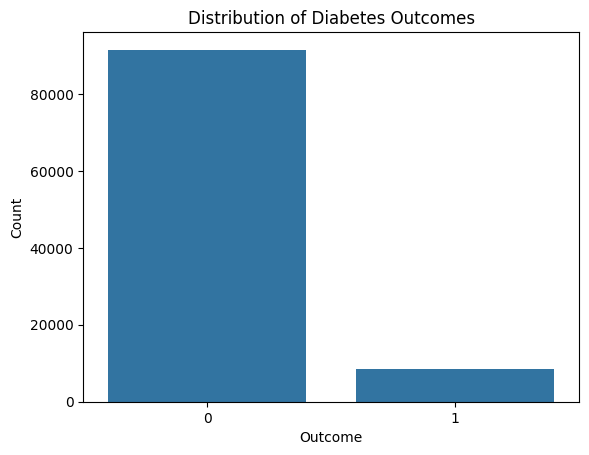

In [308]:
# print(df.isnull().sum())
sns.countplot(x=df['diabetes'], data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Label Encoder

**Review the categorical variables**
 - **if needed, we will use label encoding**

In [309]:
# Check unique values for 'gender'
print("Unique values in 'gender':", df['gender'].unique())

# Check unique values for 'smoking_history'
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'gender': ['Female' 'Male' 'Other']
Unique values in 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']


**Since Gender has 3 values, we can keep the Label encoding as-is**
**However, smoking_history has 6 values, so we will use one-hot encoding**


In [310]:
# encode the data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
#df['smoking_history'] = le.fit_transform(df['smoking_history'])
# One-Hot Encode 'smoking_history' (since it has multiple unordered categories)
df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# Display updated column names
print("Updated Columns after Encoding:", df.columns)

Updated Columns after Encoding: Index(['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')


In [311]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0,False,False,False,True,False
1,0,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False
2,1,28.0,0,0,27.32,5.7,158,0,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,0,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90,0,False,False,False,False,False
99996,0,2.0,0,0,17.37,6.5,100,0,False,False,False,False,False
99997,1,66.0,0,0,27.83,5.7,155,0,False,False,True,False,False
99998,0,24.0,0,0,35.42,4.0,100,0,False,False,False,True,False


# Feature Importance

In [312]:
# x = df.drop("diabetes",axis=1)
# y = df["diabetes"]
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(x,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=x.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

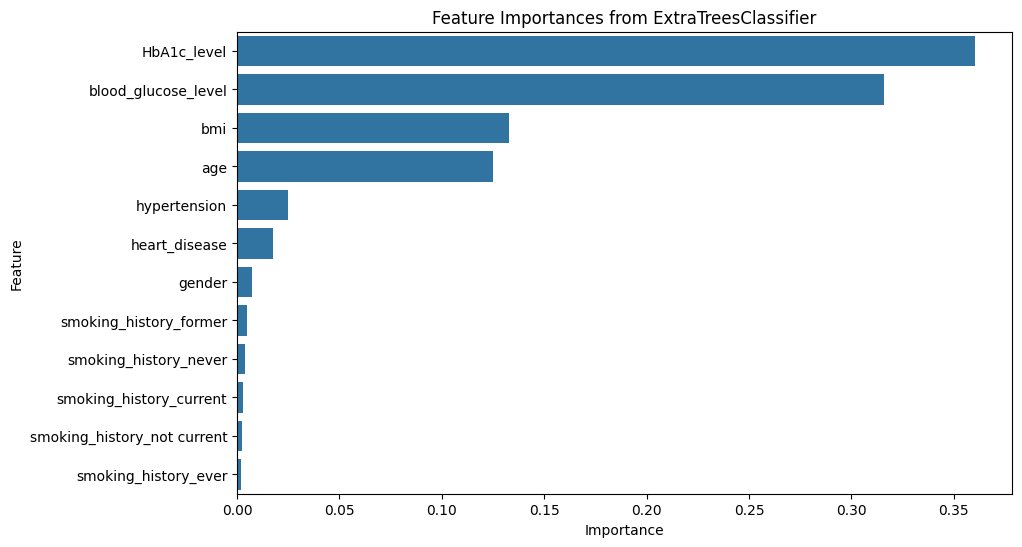

In [313]:
# Define Features and Target variables
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Train ExtraTreesClassifier to identify feature importance
model = ExtraTreesClassifier()
model.fit(X, y)
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the DataFrame by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances from ExtraTreesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Feature Selection**

In [314]:
# Keep all features for visualization & dashboard interaction
X_full = df.drop(columns=["diabetes"])  # Keeps everything except the target variable

# Optimized feature set (for model training)
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
X_selected = df[selected_features]

# Target variable remains the same
y = df["diabetes"]


Splitting Data


In [315]:
# We use StratifiedFold so that each fold in x-validation has the same proportion of diabetic and non-diabetic cases as the original dataset. 
# Also ensure balanced class distribution in each fold.
# Also find the best parameters while preventing overfitting
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Model Selection

1. Logistic Regression

In [316]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# # Define features and target
# X = df.drop(columns=["diabetes"])  # Ensure "diabetes" is the correct target column name
# y = df["diabetes"]

# Step 1. Split the data into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)


# # Initialize and train the model
# model = LogisticRegression()
# model.fit(X_train, y_train)


In [ ]:
# Step 2. Use only selected features for model training
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 3. Train the model with selected features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Step 4: Evaluate and make predictions on the new model
y_preds_selected = model.predict(X_test_selected)
print("Model Performance with Selected Features:")
print(classification_report(y_test, y_preds_selected))


**Summary**
    - **Model Accuracy is at 96%**  
    - **When the model predicts diabetes, it is correct 86% of the time**    
    - **However, the model only catches 64% of actual diabets cases**   
    - **Balanced performance based on f1-score 0.73**   

**Concerns**    
    - **We are missing 36% of the actual diabetic cases**   

Check class distribution

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


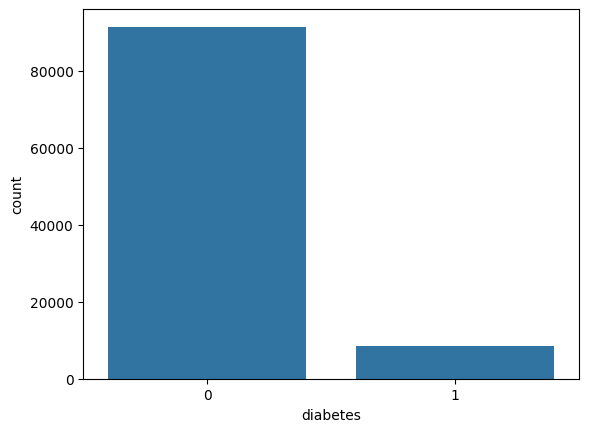

In [ ]:
import seaborn as sns

sns.countplot(x=y)
print(y.value_counts(normalize=True))  # Shows class proportions


Handling class imbalance as the Model is predicting majority as 0 meaning "no diabetes"


**Test SMOTE with new threshold 0.85**

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Train Logistic Regression Again
model_smote = LogisticRegression()
model_smote.fit(X_train_balanced, y_train_balanced)

# Predict & Evaluate
y_preds_smote = model_smote.predict(X_test_selected)
print("Model Performance after SMOTE:")
print(classification_report(y_test, y_preds_smote))


Model Performance after SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     18300
           1       0.53      0.80      0.64      1700

    accuracy                           0.92     20000
   macro avg       0.76      0.87      0.80     20000
weighted avg       0.94      0.92      0.93     20000



**Summary of Model performance after applying SMOTE**
    - **Model Accuracy dropped to 92%**  
    - **When the model predicts diabetes, it is correct 53% of the time**    
    - **However, the model now catches 80% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.64**   

**We are now only missing 20% of the actual diabetic cases**   

**Testing**
 - **Include all unit testing below**


In [ ]:
df.describe

<bound method NDFrame.describe of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
99995       0  80.0             0              0  27.32          6.2   
99996       0   2.0             0              0  17.37          6.5   
99997       1  66.0             0              0  27.83          5.7   
99998       0  24.0             0              0  35.42          4.0   
99999       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_history_1  smoking_history_2  \
0                      

In [ ]:
df.info

<bound method DataFrame.info of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
99995       0  80.0             0              0  27.32          6.2   
99996       0   2.0             0              0  17.37          6.5   
99997       1  66.0             0              0  27.83          5.7   
99998       0  24.0             0              0  35.42          4.0   
99999       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_history_1  smoking_history_2  \
0                      14